# Value

In [ ]:
# | default_exp core

In [ ]:
#|export
from fastcore.test import *
from typing import Tuple
from graphviz import Digraph
import math

In [ ]:
# |export
class Value:
    """
    This is the fundamental building block of our neural nets. This is a class that stores any scalar value and provides various mathamatical operations on it.
    It also stores the gradient of the value with respect to some scalar value. This is used to compute the gradients of the loss function with respect to the parameters of the neural net.
    """

    def __init__(
        self,
        data: float,  # This stores the value of the node
        _children: Tuple[
            "Value", ...
        ] = (),  # This stores the values of the nodes that were used to compute the current node.
        _op: str = "",  # Ths store the value of te operationthat was used to compute the current node.
        label: str = "",  # Each value can have an associated label that can be used to identify it during calling `draw_dot`
    ):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: 1
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data:.2e}, grad={self.grad:.2e}, label={self.label})"

    def __add__(
        self,
        other: "Value", # This is the other `Value` object that we want to add to the current `Value` object.
    ) -> "Value":
        """
        This is the addition function which can allow us to add 2 `Value` objects or a `Value` object and a scalar.
        It also has a `_backward` function which propagates the gradients back to the parent nodes, i.e. the nodes that were used to compute the current node.
        Using chain rule, we can compute the gradients of the parent nodes with respect to the current node.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(
        self,
        other: "Value", # This is the other `Value` object that we want to add to the current `Value` object
    ):
        """
        This is the addition function which can allow us to add 2 `Value` objects or a `Value` object and a scalar.
        It also has a `_backward` function which propagates the gradients back to the parent nodes, i.e. the nodes that were used to compute the current node.
        Using chain rule, we can compute the gradients of the parent nodes with respect to the current node.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        """
        This is an activation function which when applied returns a new `Value` object. with the tanh aspplied on the data.
        """
        n = self.data
        val = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(val, (self,), "tanh")

        def _backward():
            self.grad += (1 - val**2) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += math.exp(x) * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (other * -1)

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def backward(self):
        visited = set()
        topo_order = []

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_order.append(v)

        build_topo(self)
        self.grad = 1
        for v in reversed(topo_order):
            v._backward()
    
    def trace(self):
        """
        This function returns the nodes and edges of the graph that is formed by the `Value` objects.
        """
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build(child)
        build(self)
        return nodes, edges

    def draw_dot(self):
        """
        This function draws the graph that is formed by the `Value` objects.
        """
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        nodes, edges = self.trace()
        for n in nodes:
            uid = str(id(n))
            dot.node(name=uid, label=f"label: {n.label} | data: {n.data} | grad: {n.grad}", shape="record")
            if n._op:
                dot.node(name=f"op_{uid}", label=n._op)
                dot.edge(f"op_{uid}", uid)
        for n1, n2 in edges:
            dot.edge(str(id(n1)), f"op_{str(id(n2))}")
        return dot

In [ ]:
assert (Value(1) + Value(2)).data == (Value(3)).data
assert (Value(1) * Value(2)).data == (Value(2)).data
assert (Value(1) + Value(2) * Value(3)).data == (Value(7)).data

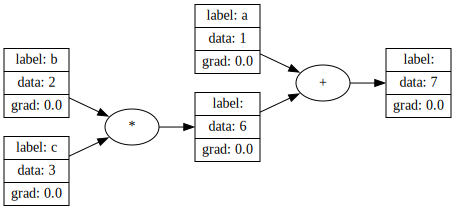

In [ ]:
(Value(1, label='a') + Value(2, label='b') * Value(3, label='c')).draw_dot()